## How to apply Shapley values in practice outside a game theory setting:

Let's say, we're interested in how each feature affects the prediction of some data point in a linear model. Consider $y, \epsilon \in \mathbb{R}^n$, and $X \in \mathbb{R}^{n\times p}$ and $\beta \in \mathbb{R}^p$ and the following linear model

$y_i = x_i^T\beta + \epsilon_i, \quad i = 1, \dots, n$

In words, the Shapley value $\phi_j$ of feature $j$ corresponds to how much $j$ contributes to the prediction of some data point compared to the average prediction for the dataset.

Denote $\hat f(x) = X\hat\beta$ the prediction function. 

Then

$$\phi_j(\hat f) = \hat\beta_jx_j - E[\hat\beta_jX_j] = \hat\beta_j(x_j - E[X_j])$$

The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training. The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

In general, exact calculation of shapley values becomes problematic if more features are added, since the computation time grows exponentially. Monte-Carlo methods for approximation is available:

$$\phi_j ≈ \frac{1}{M} \sum_{m=1}^M \left( \hat{f}(x^m_{+j}) - \hat{f}(x^m_{-j}) \right),$$

where $\hat{f}(x^m_{+j})$ is a prediction for $x$ but with a random number of feature values replaced by feature values from a random data point $z$, except for the respective value of feature $j$.

Algorithm:

for $m = 1, \dots, M$ do:

1. Draw random instance $z$ from the data matrix $X$.
2. Select subset of features $S ⊆ [p]$ where $j \notin S$.
3. Construct two new indices:
   1. With $j$ from $x$: $x_{+j}$ where all values in $x \in S$ are replaced by values in $z$.
   2. Without $j$ from $x$: $x_{-j}$ where all values in $x \in S$ are replaced by values in $z$ and also the value for $j$ is replaced (by values in $z$).
4. Compute marginal contribution: $\phi_j^m = \hat{f}(x_{+j}) - \hat{f}(x_{-j})$

Shapley value is then $\phi_j = \frac{1}{M} \sum_{m=1}^M \phi_j^m$

Let's try it out

In [1]:
from causalAssembly.models_fcm import FCM
from sympy import symbols, Eq
from sympy.stats import Gamma, Normal, Uniform, Exponential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import random

import numpy as np


In [2]:
v, w, x, y, z = symbols("v,w,x,y,z")
eq_v = Eq(v, Gamma("source_distribution", 1, 1))
eq_w = Eq(w, Uniform("error", left=-0.5, right=0.5))
eq_x = Eq(x, -7*w + Exponential("source_distribution", 0.5))
eq_y = Eq(y, 2*x + Normal("error", 0, 1))
eq_z = Eq(z, 2*v - 7*w + x - 2*y +  Gamma("noise", 0.5, 1))

eq_list = [eq_v, eq_w, eq_x, eq_y, eq_z]

# Create instance
test_fcm = FCM()
# Input list of equations this automatically
# induces the DAG etc.
test_fcm.input_fcm(eq_list)


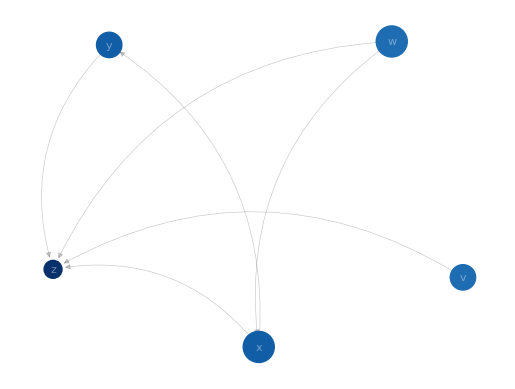

In [3]:
test_fcm.show()

In [4]:
test_df = test_fcm.sample(size=1000)
test_df.head()

,v,w,x,y,z
0,0.087407,-0.463077,6.124014,12.835061,-16.129719
1,0.411345,0.165636,0.638365,1.832679,-3.266083
2,0.165865,0.438511,-1.979913,-3.904973,3.432531
3,0.739910,0.237464,0.286433,0.476691,-0.820311
4,0.997842,-0.301673,5.787966,13.744818,-17.045657


In [5]:
test_fcm.intervene_on({x: Normal("error", 0, 1)})


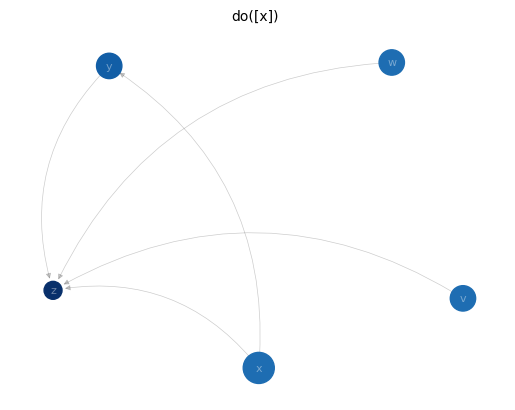

In [6]:
test_fcm.show_mutilated_dag()

In [7]:
outlier_sample = test_fcm.interventional_sample(size=1)


In [8]:
outlier_sample.head()

,v,w,x,y,z
0,0.737665,-0.006752,-0.308203,-1.410805,4.166677


Assume DAG is known and coefficients are also known.

In [24]:
def situational_importance(val :float, coeff :float, data :np.ndarray):
    return coeff * (val - data.mean())

In [48]:
test_fcm.display_functions()[z].as_poly().coeffs()[:-1]

[1, -2, 2, -7]

In [57]:
outlier_sample[str(x)]

0   -0.308203
Name: x, dtype: float64

In [58]:
for node in set(test_fcm.nodes) - set(test_fcm.source_nodes):
    coeffs = test_fcm.display_functions()[node].as_poly().coeffs()[:-1]
    parents = test_fcm.parents_of(node, which_graph=test_fcm.graph)
    for i,coeff in enumerate(coeffs):
        situational_importance(val=outlier_sample[str(node)], coeff=coeff, data=test_df[str(parents[i])])


3.16313532964851
-4.34397171183854
0.376507443551435
-29.1350454614149
2.18911438474497
-6.81099252791244


/Users/kgoebler/Projects/causal_reading/venv_causal_reading_group/lib/python3.11/site-packages/sympy/core/sympify.py:444: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return sympify(coerce(a))


In [ ]:
situational_importance()

In [41]:
features = test_df[["v", "w", "x", "y"]]
target = test_df["z"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=2022
)

In [42]:
# prepare a model
f = make_pipeline(StandardScaler(), LinearRegression())

# fit the model
f.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [43]:
features.columns


Index(['v', 'w', 'x', 'y'], dtype='object')

pick a sample instance to explain.

In [44]:
sample_idx = 0
x = X_test.iloc[sample_idx]

In [45]:
# calculate the shaply value for feature j
j = 1
M = 1000
n_features = len(x)
marginal_contributions = []
feature_idxs = list(range(n_features))
feature_idxs.remove(j) # remove the feature j


In [46]:
for _ in range(M):
    z = X_train.sample(1).values[0]
    x_idx = random.sample(feature_idxs, min(max(int(0.2*n_features), random.choice(feature_idxs)), int(0.8*n_features)))
    z_idx = [idx for idx in feature_idxs if idx not in x_idx]

    # construct two new instances
    x_plus_j = np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])
    x_minus_j = np.array([z[i] if i in z_idx + [j] else x[i] for i in range(n_features)])

    # calculate marginal contribution
    marginal_contribution = f.predict(x_plus_j.reshape(1, -1)) - f.predict(x_minus_j.reshape(1, -1))
    marginal_contributions.append(marginal_contribution)

phi_j_x = sum(marginal_contributions) / len(marginal_contributions)  # the shaply value

/var/folders/5c/j8795m4d13n_xmcr1vs4r73r0000gn/T/ipykernel_49831/3398799190.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_plus_j = np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])
/var/folders/5c/j8795m4d13n_xmcr1vs4r73r0000gn/T/ipykernel_49831/3398799190.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_minus_j = np.array([z[i] if i in z_idx + [j] else x[i] for i in range(n_features)])
/Users/kgoebler/Projects/causal_reading/venv_causal_reading_group/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted w

In [47]:
print(f"Shaply value for feature j: {phi_j_x}")

Shaply value for feature j: [0.99242403]


In [48]:
import shap

In [49]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [50]:
explainer = shap.KernelExplainer(lm.predict, X_train)
shap_values = explainer.shap_values(X_test.iloc[sample_idx,:])

Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [51]:
shap_values

array([-0.30170844,  0.87705729,  0.62132733, -2.03756506])